In [32]:
import os
import h5py
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
from scipy.optimize import root
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
data_dir = "krylov_data3"
exact_file = "hubbard_exact_3.hdf5"
all_files = os.listdir(data_dir)
assert exact_file in all_files
ev_files = [f for f in all_files if "eigenvalues" in f]
print(len(ev_files))

11


In [34]:
# Get the exact energy.
f_exact = h5py.File(data_dir + "/" + exact_file, "r")
energy_exact = np.min(f_exact["energies"])
print(f"Exact energy is {energy_exact}.")
f_exact.close()

Exact energy is (1.0717967697244912+0j).


In [35]:
dfs = []
for evf in ev_files:
    fname = data_dir + "/" + evf
    # Get the number of steps.
    f = h5py.File(fname, "r")
    steps = f["steps"][()]
    f.close()
    # Get the upper bound.
    # fname2 = fname.replace("eigenvalues", "bound")
    # bound_df = pd.read_hdf(fname2)
    # Get the dataframe with energy vs. d
    df = pd.read_hdf(fname, key="eigenvalues")
    df["error"] = abs(df["energy"] - energy_exact) / abs(energy_exact)
    df["steps"] = steps
    df.set_index("d")
    # df_concat = pd.concat([df, bound_df], axis=1)
    # dfs.append(df_concat)
    dfs.append(df)
df_total = pd.concat(dfs)
print(df_total)

     d           eps    energy  num_pos     error  steps
i                                                       
0    3  1.000000e-08  1.155197        3  0.077814     40
1    4  1.000000e-08  1.121213        4  0.046106     40
2    5  1.000000e-08  1.100667        5  0.026937     40
3    6  1.000000e-08  1.094194        6  0.020897     40
4    7  1.000000e-08  1.089019        6  0.016069     40
..  ..           ...       ...      ...       ...    ...
9   12  1.000000e-08  1.084563        8  0.011911     10
10  13  1.000000e-08  1.081899        9  0.009425     10
11  14  1.000000e-08  1.080137        9  0.007781     10
12  15  1.000000e-08  1.078892        9  0.006620     10
13  16  1.000000e-08  1.077785       10  0.005587     10

[154 rows x 6 columns]


In [36]:
df_small = df_total[df_total["d"] >= 20]
print(df_small)

Empty DataFrame
Columns: [d, eps, energy, num_pos, error, steps]
Index: []


In [37]:
df_small = df_total[df_total["d"] >= 14]
print(df_small.head())

     d           eps    energy  num_pos     error  steps
i                                                       
11  14  1.000000e-08  1.075129        9  0.003109     40
12  15  1.000000e-08  1.074521        9  0.002541     40
13  16  1.000000e-08  1.074055       10  0.002107     40
11  14  1.000000e-08  1.073573        9  0.001658    100
12  15  1.000000e-08  1.073239        9  0.001346    100


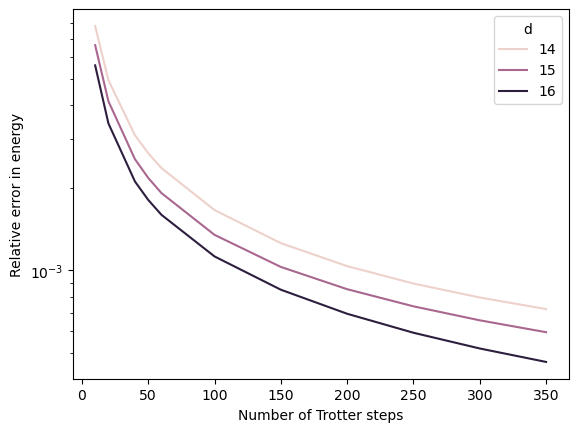

In [ ]:
fig, ax = plt.subplots()
ax.set_yscale("log")
sns.lineplot(ax=ax, data=df_small, x="steps", y="error", hue="d")
ax.set_xlabel("Number of Trotter steps")
ax.set_ylabel("Relative error in energy")
# plt.savefig("hubbard_2_error.pdf")

In [ ]:
def find_num_steps(steps, errors, accuracy, t0):
    """Find the number of steps for a given accuracy by interpolation."""

    assert np.min(errors) <= accuracy <= np.max(errors),\
        f"Accuracy {accuracy} must be between {np.min(errors)} and {np.max(errors)}"
    spline = CubicSpline(steps, errors)
    solution = root(lambda nt: spline(nt) - accuracy, t0)
    if not solution.success:
        print("Solver did not converge.")
    return solution.x

In [68]:
for d in range(3, 17):
    df_d = df_total[df_total["d"] == d]
    errors = df_d["error"].to_numpy()
    print(d, np.min(errors), np.max(errors))

3 0.06532710968040396 0.11698328358423885
4 0.01972360238534263 0.07941508079628701
5 0.014599482124816545 0.05176231601339035
6 0.009370240748122333 0.036557072732137756
7 0.007046076743066753 0.029684135353631624
8 0.005270827229249383 0.02429280282065501
9 0.003274083643105604 0.020205549610160807
10 0.0020959565735139355 0.017554579864803785
11 0.0015860422546242975 0.014910676644958527
12 0.001232472666553656 0.01191097612495442
13 0.0009129273816246957 0.00942532542687817
14 0.0007215577659368376 0.007781386957323865
15 0.0005943231798429033 0.006619507565734832
16 0.0004630031671156948 0.005586733346725518


In [80]:
# For each given error, find how many steps it would take to produce, along wih the required d.
errs = [0.1, 0.1, 1e-2, 1e-2, 1e-2, 1e-3, 5e-4]
ds = [3, 4, 7, 8, 9, 14, 15]
nt0 = [50, 50, 250, 200, 200, 200, 200] # Guess at number of steps.

for err, d, nt in zip(errs, ds, nt0):
    df_d = df_total[df_total["d"] == d]
    df_d.sort_values("steps", inplace=True)
    errors = df_d["error"].to_numpy()
    steps = df_d["steps"].to_numpy()
    steps = find_num_steps(steps, errors, err, nt)
    print(err, d, steps)

0.1 3 [15.70866727]
0.1 4 [2.82329138]
0.01 7 [123.79833359]
0.01 8 [70.82831763]
0.01 9 [45.95814028]
0.001 14 [210.71838082]
0.0005 15 [438.78258878]


/var/folders/rv/3v7hvpgn6ks14zr4w90jz4zc0000gn/T/ipykernel_2385/1125365208.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d.sort_values("steps", inplace=True)
